In [ ]:
!pip install tensorflow_docs

In [ ]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Softmax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import InceptionV3, EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_inception
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot
from tensorflow.keras.models import save_model

In [ ]:
# Function to load and preprocess images based on the chosen model
def prض2eprocess_images(X, model_name):
    if model_name == 'InceptionV3':
        return preprocess_input_inception(X)
    elif model_name == 'EfficientNet':
        return preprocess_input_efficientnet(X)
    elif model_name == 'ResNet':
        return preprocess_input_resnet(X)
    elif model_name == 'VGG16':
        return preprocess_input_vgg(X)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

# Function to build a specified pre-trained model
def build_pretrained_model(model_name, input_shape, num_classes):
    if model_name == 'EfficientNet':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'ResNet':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    # Add custom dense layers on top of the pre-trained base
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Function to plot the model history
def plot_model_history(model_history, metric, plot_name):
    sns.set(style='darkgrid')  # Use Seaborn directly to set the style
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({'Model': model_history}, metric=metric)
    plt.title(f'{metric.upper()}')
    plt.ylim([0, 1])
    plt.savefig(f'{plot_name}.png')
    plt.close()

# Function to load and preprocess image paths
def load_image_paths(drive_folder_path, image_types=('*.jpg', '*.png', '*.jpeg', '*.gif')):
    image_paths = []
    classes = []

    # Get the list of subfolders inside the main folder
    subfolders = [f.path for f in os.scandir(drive_folder_path) if f.is_dir()]

    for folder in subfolders:
        class_name = os.path.basename(folder)  # Get the name of the folder as the class
        class_images = []

        # Iterate over specified image types
        for image_type in image_types:
            class_images.extend(glob(os.path.join(folder, image_type)))

        image_paths.extend(class_images)
        classes.extend([class_name] * len(class_images))

    return image_paths, classes

# Function to load images and labels
def load_images_and_labels(image_paths, target_size=(256,256)):
    images = []
    labels = []

    for image_path in image_paths:
        image = load_img(image_path, target_size=target_size)
        image = img_to_array(image)

        label = image_path.split(os.path.sep)[-2]
        images.append(image)
        labels.append(label)


بي+-/*    return np.array(images), np.array(labels)

In [4]:
# Main function for training and evaluating pre-trained models with fine-tuning
def main_with_fine_tuning():
    SEED = 999
    np.random.seed(SEED)

    # Load the dataset into memory, normalizing the images and one-hot encoding the labels
    drive_folder_path = '/content/drive/MyDrive/Archaeological_Sites_Classification'  # Update with your actual folder path
    image_paths, classes = load_image_paths(drive_folder_path)
    X, y = load_images_and_labels(image_paths)
    X = X.astype('float') / 255.0
    label_binarizer = LabelBinarizer()
    y = label_binarizer.fit_transform(classes)

    # Display class distribution
    class_df = pd.DataFrame({'Class': classes})
    print(class_df['Class'].value_counts())

    (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=SEED)
    print(f'Shape of X_train: {X_train.shape}')
    print(f'Shape of X_test: {X_test.shape}')
    print(f'Shape of y_train: {y_train.shape}')
    print(f'Shape of y_test: {y_test.shape}')

    EPOCHS = 30
    BATCH_SIZE = 64

    pretrained_models = ['InceptionV3', 'EfficientNet', 'ResNet', 'VGG16']

    for model_name in pretrained_models:
        print(f"\nTraining and evaluating {model_name} with fine-tuning...\n")

        # Build and compile the pre-trained model
        base_model = build_pretrained_model(model_name, (256, 256, 3), len(label_binarizer.classes_))
        base_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Fine-tune the pre-trained model
        for layer in base_model.layers[:-5]:  # Unfreeze last few layers for fine-tuning
            layer.trainable = True

        base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

                # Apply data augmentation during training
        if model_name == 'EfficientNet':
            train_datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=20,
        fill_mode='nearest',
        validation_split = 0.20
            )
        else:
            train_datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=20,
        fill_mode='nearest',
        validation_split = 0.20
            )


        train_datagen.fit(X_train)

        train_generator = train_datagen.flow(X_train, y_train, batch_size = BATCH_SIZE, subset='training')



        # Train the model with fine-tuning and data augmentation
        history = base_model.fit_generator(train_generator, validation_data=(X_test, y_test), epochs=EPOCHS)

        # Evaluate the model
        result = base_model.evaluate(X_test, y_test)
        print(f'Test accuracy ({model_name} with fine-tuning): {result[1]}')

        # Print classification report
        y_pred = base_model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)
        print(f'\nClassification Report ({model_name} with fine-tuning):\n')
        print(classification_report(y_true_classes, y_pred_classes, target_names=label_binarizer.classes_))
        # Plot learning curve
        plot_model_history(history, 'accuracy', f'{model_name}_learning_curve_fine_tuned')


# run script
if __name__ == "__main__":
    main_with_fine_tuning()

um_qais          763
jarash           703
Wadi_Rum         614
Petra            607
Ajloun           572
Roman_Theater    520
Name: Class, dtype: int64
Shape of X_train: (3023, 256, 256, 3)
Shape of X_test: (756, 256, 256, 3)
Shape of y_train: (3023, 6)
Shape of y_test: (756, 6)

Training and evaluating InceptionV3 with fine-tuning...

87910968/87910968 [==============================] - 5s 0us/step


<ipython-input-4-ae421316b683>:68: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = base_model.fit_generator(train_generator, validation_data=(X_test, y_test), epochs=EPOCHS)


Epoch 1/30
38/38 [==============================] - 98s 1s/step - loss: 0.8306 - accuracy: 0.6978 - val_loss: 0.8059 - val_accuracy: 0.7235
Epoch 2/30
38/38 [==============================] - 33s 864ms/step - loss: 0.2306 - accuracy: 0.9239 - val_loss: 0.4066 - val_accuracy: 0.8452
Epoch 3/30
38/38 [==============================] - 33s 855ms/step - loss: 0.1022 - accuracy: 0.9686 - val_loss: 0.3344 - val_accuracy: 0.8823
Epoch 4/30
38/38 [==============================] - 33s 852ms/step - loss: 0.0588 - accuracy: 0.9814 - val_loss: 0.3515 - val_accuracy: 0.8902
Epoch 5/30
38/38 [==============================] - 33s 861ms/step - loss: 0.0544 - accuracy: 0.9831 - val_loss: 0.3123 - val_accuracy: 0.8968
Epoch 6/30
38/38 [==============================] - 33s 847ms/step - loss: 0.0355 - accuracy: 0.9893 - val_loss: 0.3010 - val_accuracy: 0.8915
Epoch 7/30
38/38 [==============================] - 34s 869ms/step - loss: 0.0312 - accuracy: 0.9884 - val_loss: 0.4254 - val_accuracy: 0.8783
Ep

<ipython-input-4-ae421316b683>:68: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = base_model.fit_generator(train_generator, validation_data=(X_test, y_test), epochs=EPOCHS)


Epoch 1/30
38/38 [==============================] - 70s 963ms/step - loss: 1.3699 - accuracy: 0.5362 - val_loss: 1.8094 - val_accuracy: 0.1561
Epoch 2/30
38/38 [==============================] - 33s 864ms/step - loss: 0.5902 - accuracy: 0.8222 - val_loss: 1.7979 - val_accuracy: 0.1508
Epoch 3/30
38/38 [==============================] - 33s 850ms/step - loss: 0.3401 - accuracy: 0.8876 - val_loss: 1.7950 - val_accuracy: 0.1508
Epoch 4/30
38/38 [==============================] - 34s 873ms/step - loss: 0.2320 - accuracy: 0.9202 - val_loss: 1.7924 - val_accuracy: 0.1376
Epoch 5/30
38/38 [==============================] - 33s 848ms/step - loss: 0.1711 - accuracy: 0.9458 - val_loss: 1.7935 - val_accuracy: 0.1495
Epoch 6/30
38/38 [==============================] - 34s 871ms/step - loss: 0.1175 - accuracy: 0.9682 - val_loss: 1.8062 - val_accuracy: 0.1574
Epoch 7/30
38/38 [==============================] - 34s 877ms/step - loss: 0.0739 - accuracy: 0.9797 - val_loss: 1.8176 - val_accuracy: 0.2050

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


94765736/94765736 [==============================] - 5s 0us/step


<ipython-input-4-ae421316b683>:68: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = base_model.fit_generator(train_generator, validation_data=(X_test, y_test), epochs=EPOCHS)


Epoch 1/30
38/38 [==============================] - 86s 1s/step - loss: 0.7024 - accuracy: 0.7437 - val_loss: 2.8219 - val_accuracy: 0.1706
Epoch 2/30
38/38 [==============================] - 34s 877ms/step - loss: 0.1734 - accuracy: 0.9409 - val_loss: 3.1128 - val_accuracy: 0.1587
Epoch 3/30
38/38 [==============================] - 34s 889ms/step - loss: 0.0835 - accuracy: 0.9777 - val_loss: 2.5860 - val_accuracy: 0.1587
Epoch 4/30
38/38 [==============================] - 35s 898ms/step - loss: 0.0495 - accuracy: 0.9872 - val_loss: 2.7797 - val_accuracy: 0.1601
Epoch 5/30
38/38 [==============================] - 35s 902ms/step - loss: 0.0415 - accuracy: 0.9888 - val_loss: 2.4053 - val_accuracy: 0.1720
Epoch 6/30
38/38 [==============================] - 35s 902ms/step - loss: 0.0267 - accuracy: 0.9934 - val_loss: 3.3799 - val_accuracy: 0.1587
Epoch 7/30
38/38 [==============================] - 35s 898ms/step - loss: 0.0329 - accuracy: 0.9897 - val_loss: 2.8973 - val_accuracy: 0.1587
Ep

<ipython-input-4-ae421316b683>:68: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = base_model.fit_generator(train_generator, validation_data=(X_test, y_test), epochs=EPOCHS)


Epoch 1/30
38/38 [==============================] - 149s 3s/step - loss: 1.2839 - accuracy: 0.4915 - val_loss: 1.0601 - val_accuracy: 0.6098
Epoch 2/30
38/38 [==============================] - 53s 1s/step - loss: 0.6438 - accuracy: 0.7586 - val_loss: 0.9094 - val_accuracy: 0.6481
Epoch 3/30
38/38 [==============================] - 53s 1s/step - loss: 0.4894 - accuracy: 0.8177 - val_loss: 0.8810 - val_accuracy: 0.6336
Epoch 4/30
38/38 [==============================] - 53s 1s/step - loss: 0.3658 - accuracy: 0.8669 - val_loss: 0.7335 - val_accuracy: 0.7024
Epoch 5/30
38/38 [==============================] - 53s 1s/step - loss: 0.3426 - accuracy: 0.8805 - val_loss: 0.8781 - val_accuracy: 0.6825
Epoch 6/30
38/38 [==============================] - 53s 1s/step - loss: 0.2477 - accuracy: 0.9219 - val_loss: 0.7514 - val_accuracy: 0.7077
Epoch 7/30
38/38 [==============================] - 53s 1s/step - loss: 0.2125 - accuracy: 0.9272 - val_loss: 1.1196 - val_accuracy: 0.5979
Epoch 8/30
38/38 [=

In [ ]:
الاى


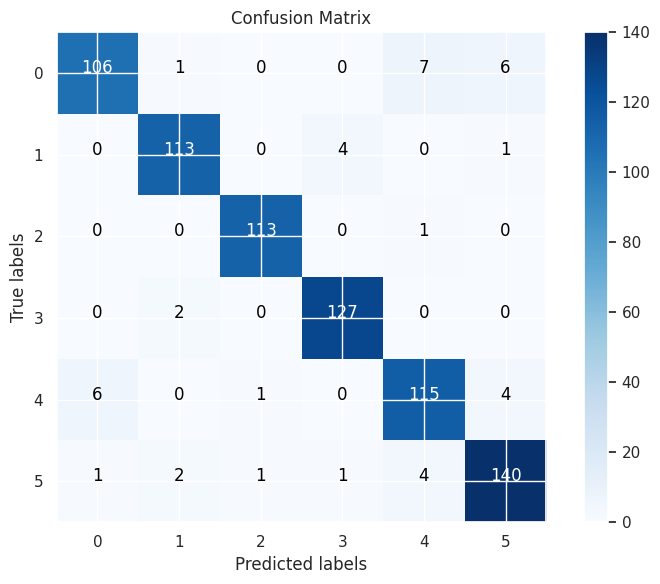